<a href="https://colab.research.google.com/github/ritwikraha/computer-needs-glasses/blob/master/image-generation/Attend_and_Excite_with_Language_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install -qq diffusers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.5/222.5 MB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.2.1+cu121 requires torch==2.2.1, but you have torch 2.2.2 which is incompatible.
torchtext 0.17.1 requires torch==2.2.1, but you have torch 2.2.2 which is incompatible.
torchvision 0.17.1+cu121 requires torch==2.2.1, but you have torch 2.2.2 which is incompatible.


In [12]:
import torch
from diffusers import StableDiffusionAttendAndExcitePipeline
from transformers import AutoModelForCausalLM, AutoTokenizer

In [13]:
pipe = StableDiffusionAttendAndExcitePipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16
).to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [27]:
prompt = "a man riding a green bike on a sand dune"

# use get_indices function to find out indices of the tokens you want to alter
indices = pipe.get_indices(prompt)

In [15]:
language_model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen1.5-0.5B-Chat", device_map="auto")
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen1.5-0.5B-Chat")

config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/206 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [31]:
messages = [
    {
        "role": "system",
        "content": "Follow the examples and return the expected output",
    },
    {
        "role": "user",
        "content": "{0: 'Rain</w>', 1: 'falls</w>', 2: 'on</w>', 3: 'the</w>', 4: 'plain</w>'}",
    },
    {
        "role": "assistant",
        "content": "0,4",
    },
    {
        "role": "user",
        "content": "{0: 'Children</w>', 1: 'playing</w>', 2: 'in</w>',  3: 'park</w>'}",
    },
    {
        "role": "assistant",
        "content": "0,3",
    },

    {
        "role": "user",
        "content": "{0: 'A</w>', 1: 'beautiful</w>', 2: 'sunset</w>', 3: 'over</w>', 4: 'the</w>', 5: 'ocean</w>'}",
    },
    {
        "role": "assistant",
        "content": "2,5",
    },
    {
        "role": "user",
        "content": "{0: 'The</w>', 1: 'loud</w>', 2: 'roar</w>', 3: 'of</w>', 4: 'the</w>', 5: 'waterfall</w>'}",
    },
    {
        "role": "assistant",
        "content": "5",
    },
    {
        "role": "user",
        "content": "{0: 'Stars</w>', 1: 'twinkle</w>', 2: 'in</w>', 3: 'the</w>', 4: 'night</w>', 5: 'sky</w>'}",
    },
    {
        "role": "assistant",
        "content": "0,4,5",
    },
    {
        "role": "user",
        "content": "{0: 'Green</w>', 1: 'Leaves</w>', 2: 'rustle</w>', 3: 'in</w>', 4: 'the</w>', 5: 'gentle</w>', 6: 'breeze</w>'}",
    },
    {
        "role": "assistant",
        "content": "1,6",
    },
    {
        "role": "user",
        "content": "{0: 'A</w>', 1: 'cold</w>', 2: 'wind</w>', 3: 'blows</w>', 4: 'through</w>', 5: 'the</w>', 6: 'valley</w>'}",
    },
    {
        "role": "assistant",
        "content": "2,6",
    },
    {
        "role": "user",
        "content": "{0: 'Some</w>', 1: 'Fishes</w>', 2: 'swim</w>', 3: 'in</w>', 4: 'the</w>', 5: 'clear</w>', 6: 'blue</w>', 7: 'lake</w>'}",
    },
    {
        "role": "assistant",
        "content": "1,7",
    },
    {"role": "user", "content": f"{indices}"},
]


In [33]:
text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
model_inputs = tokenizer([text], return_tensors="pt").to("cuda")
with torch.no_grad():
    generated_ids = language_model.generate(
        model_inputs.input_ids, max_new_tokens=512, temperature=0.0, do_sample=False
        )
    generated_ids = [
        output_ids[len(input_ids) :]
        for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    output_generation = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[
        0
    ]

In [38]:
sampled_token_indices = list(map(int, output_generation.split(",")))
print(output_generation)

1,10


In [39]:
seed = 49
generator = torch.Generator("cuda").manual_seed(seed)

In [40]:
print(sampled_token_indices)

[1, 10]


  0%|          | 0/50 [00:00<?, ?it/s]

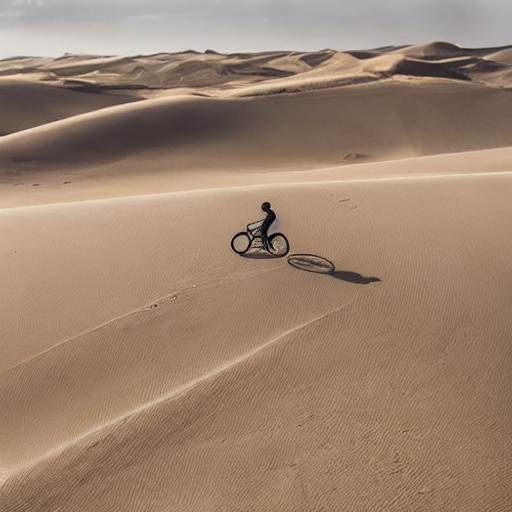

In [41]:
image = pipe(
    prompt=prompt,
    token_indices=sampled_token_indices,
    guidance_scale=7.5,
    generator=generator,
    num_inference_steps=50,
    max_iter_to_alter=25,
).images[0]

image